In [3]:

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from peerannot.models.aggregation.multinomial_binary_online import (
    VectorizedMultinomialBinaryOnlineMongo,
)
from peerannot.models.aggregation.types import ClassMapping, TaskMapping, WorkerMapping

# Batch 1: 4 tasks
batch1 = {
    "task_A": {
        "user_001": "Quercus robur",
        "user_002": "Betula pendula",
    },
    "task_B": {
        "user_003": "Pinus sylvestris",
    },
    "task_C": {
        "user_001": "Fagus sylvatica",
        "user_004": "Quercus robur",
    },
    "task_D": {
        "user_002": "Betula pendula",
        "user_005": "Acer platanoides",
    },
}



# Batch 2: 5 tasks
batch2 = {
    "task_A": {
        "user_003": "Pinus sylvestris",
        "user_004": "Quercus robur",
        "user_005": "Quercus robur",
    },
    "task_B": {
        "user_002": "Pinus sylvestris",
        "user_005": "Pinus sylvestris",
    },
    "task_E": {
        "user_001": "Fagus sylvatica",
        "user_002": "Fagus sylvatica",
    },
    "task_F": {
        "user_004": "Tilia cordata",
    },
    "task_G": {
        "user_003": "Pinus sylvestris",
        "user_001": "Acer platanoides",
        "user_005": "Fagus sylvatica",
    },
}





/home/jozef/Desktop/repos/peerannot/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
# add more models (dropdown widget)
# one slider for 2 batches
# visual. module 
# visualize raw data
# add information about docker
# 

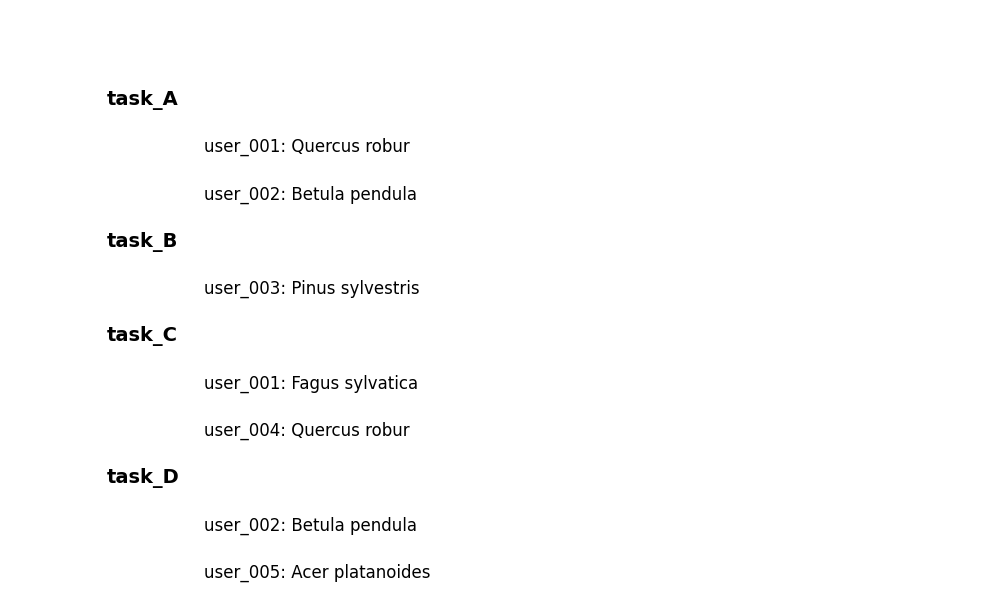

In [5]:


fig, ax = plt.subplots(figsize=(10, 6))

y_pos = 0.8

for task, users in batch1.items():
    ax.text(0.1, y_pos, task, fontsize=14, fontweight='bold')
    y_pos -= 0.1  
    for user, species in users.items():
        ax.text(0.2, y_pos, f"{user}: {', '.join([species])}", fontsize=12)
        y_pos -= 0.1 

ax.axis('off')

plt.tight_layout()
plt.show()


VectorizedMultinomialBinaryOnlineMongo is an online EM-based aggregation algorithm for crowdsourced labels, designed to work with sparse data stored in a MongoDB backend.
It extends SparseMongoOnlineAlgorithm.

It handles sparse task x worker x class matrices (`sparse.COO`) to store only non-zero label assignments.

Model supports online updates, meaning it can incrementally update worker reliabilities (pi) without recomputing everything from scratch.

VectorizedMultinomialBinaryOnlineMongo for each worker stores a single scalar -- current estimate of worker reliability.

In [6]:
from peerannot.models.aggregation.diagonal_multinomial_online import DiagonalMultinomialOnline, VectorizedDiagonalMultinomialOnlineMongo


model = VectorizedDiagonalMultinomialOnlineMongo()
model.drop()

model.process_batch(batch1)
model.get_answers()




2025-10-07 13:50:48.720 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 000 | L=-0.236910 | delta=inf | 14.086s
2025-10-07 13:50:48.736 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 001 | L=-0.218946 | delta=7.58e-02 | 0.015s
2025-10-07 13:50:48.752 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 002 | L=-0.203748 | delta=6.94e-02 | 0.015s
2025-10-07 13:50:48.768 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 003 | L=-0.191538 | delta=5.99e-02 | 0.015s
2025-10-07 13:50:48.784 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 004 | L=-0.182278 | delta=4.83e-02 | 0.015s
2025-10-07 13:50:48.800 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 005 | L=-0.175587 | delta=3.67e-02 | 0.015s
2025-10-07 13:50:48.816 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 006 | L=-0.170903 | delta=2.67e-02 | 0.015s
2025-10-07 13:50:48.832 | DEBUG    | peerannot.helpers.logging:log

array(['Betula pendula', 'Pinus sylvestris', 'Betula pendula',
       'Betula pendula'], dtype='<U16')

1. Batch preparation:
`process_batch` calls methods  to prepare `batch_matrix`, a 3 dimensional **one-hot encoded** array of shape n_tasks x n_workers x n_classes and batch appropriate mappings, i.e.  mappings that keep track of position of tasks, workers and classes in the array.
In the above example the 3 dimensional array will be of shape 4 x 5 x 5 with following mapping.

```python
task_mapping={'task_A': 0, 'task_B': 1, 'task_C': 2, 'task_D': 3}
worker_mapping={'user_001': 0, 'user_002': 1, 'user_003': 2, 'user_004': 3, 'user_005': 4}
class_mapping={'Quercus robur': 0, 'Betula pendula': 1, 'Pinus sylvestris': 2, 'Fagus sylvatica': 3, 'Acer platanoides': 4}
```

2.Soft vote calculation:
The `batch_-_matrix` input array (n_tasks x n_workers x n_classes) is collapsed across workers to compute `batch_T`, a 2D array (n_tasks x n_classes) containing per-task class probability distributions.

Each row in batch_T is the normalized frequency of worker votes for that task, so it reflects soft voting (label proportions).


3. Iterative EM updates:
The prepared `batch_matrix` and `batch_T` are used in the iterative EM loop, that runs until convergence or maxiter iterations reached.
Inside each iteration:
1. M-step: Giben current posteriors (`batch_T`), estimate batch_rho (class prior distribution) and batch_pi (worker reliability)
2. E-step: Given new parameters (batch_pi, batch_rho) recomputer posteriors (`batch_T`)
3. log-likelihood calculation: log of total probability of observed labels under current parameters
4. convergence check


After the loop online updates are performed. Updattheed probabilities (`batch_T`, `batch_rho` and `batch_pi`) are pused into the store.


In [7]:

model.process_batch(batch2)

model.get_answers()
print(model.T.shape)


2025-10-07 13:50:49.598 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 000 | L=-0.302684 | delta=inf | 0.018s
2025-10-07 13:50:49.621 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 001 | L=-0.142557 | delta=5.29e-01 | 0.023s
2025-10-07 13:50:49.639 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 002 | L=-0.155327 | delta=8.96e-02 | 0.017s
2025-10-07 13:50:49.658 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 003 | L=-0.160884 | delta=3.58e-02 | 0.018s
2025-10-07 13:50:49.674 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 004 | L=-0.164452 | delta=2.22e-02 | 0.015s
2025-10-07 13:50:49.690 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 005 | L=-0.167115 | delta=1.62e-02 | 0.015s
2025-10-07 13:50:49.706 | DEBUG    | peerannot.helpers.logging:log_em_iter:26 - [EM] Iter 006 | L=-0.169196 | delta=1.24e-02 | 0.015s
2025-10-07 13:50:49.722 | DEBUG    | peerannot.helpers.logging:log_

(7, 6)


When we call above, the following happens:

1. Batch preparation
Just like with batch1, the new batch batch2 is transformed into a 3D one-hot encoded array `batch_matrix` (n_tasks x n_workers x n_classes). Mappings for tasks, workers, and classes are created or updated to reflect the current batch.

2.Soft vote calculation:
`batch_matrix` is collapsed along the worker dimension to compute `batch_T`, a 2D array (n_tasks x n_classes) representing the normalized frequency of worker votes per task. This gives the soft label distribution for the new tasks.

2a. Blending with previous estimates:
If previous task-class probabilities exist (from batch1), the new estimates are blended with the stored ones using a convex combination with weight gamma. This ensures continuity and prevents overwriting prior knowledge, allowing the model to update incrementally.


3. Iterative EM updates:
The EM loop runs on the new batch:

M-step: Given current posteriors (`batch_T`), estimate batch-specific parameters `batch_rho` (class priors) and `batch_pi` (worker reliabilities).

E-step: Recompute task posteriors (`batch_T`) using updated parameters.

Log-likelihood: Calculate the probability of observed labels under current parameters to monitor convergence.

Convergence check: Stop if the maximum number of iterations is reached or the change in log-likelihood is below a threshold.

Online update:
Updated probabilities (`batch_T`, `batch_rho`, `batch_pi`) are merged with the stored model state in the database, effectively making the model incremental and online.

Answer retrieval:
model.get_answers() returns the current task-class predictions, reflecting both the new batch and prior knowledge from batch1.

Following code cells demonstrate how the model works from the inside out.

We start by initializing the model and preparing mappings for tasks, workers, and classes. The batch is then transformed into a one-hot encoded matrix, which serves as input to the EM algorithm.

A custom EM loop (em_trace) is implemented to iteratively estimate:
- batch_rho: class priors
- batch_pi: worker reliabilities
- batch_T: posterior probabilities for each task

The loop logs intermediate states, including the log-likelihood, at each iteration. After convergence, an **online update** merges the batch estimates into the model.

In [8]:
import numpy as np
from typing import Dict, Any, Tuple


def get_global_params(model) -> Dict[str, Any]:
    """Safely fetch global parameters from model."""
    def safe_attr(attr):
        try:
            return getattr(model, attr)
        except Exception:
            return None

    return {
        "rho": safe_attr("rho"),
        "pi": safe_attr("pi"),
        "T": safe_attr("T"),
    }

def remap_vector_to_global(vec, local_map, global_coll):
    n = global_coll.count_documents({})
    global_vec = np.zeros(n)
    for k, v in local_map.items():
        doc = global_coll.find_one({"_id": k})
        if doc:
            global_vec[doc["index"]] = vec[v]
    return global_vec


def remap_T_to_global(batch_T, task_mapping, class_mapping, model):
    """Embed local T into global shape (task x class)."""
    n_tasks = model.task_mapping.count_documents({})
    n_classes = model.class_mapping.count_documents({})

    # Build local→global index maps
    task_map = {v: model.task_mapping.find_one({"_id": k})["index"] for k, v in task_mapping.items()}
    class_map = {v: model.class_mapping.find_one({"_id": k})["index"] for k, v in class_mapping.items()}

    # Initialize global T
    global_T = np.zeros((n_tasks, n_classes))
    
    for t_local, t_global in task_map.items():
        for c_local, c_global in class_map.items():
            global_T[t_global, c_global] = batch_T[t_local, c_local]
    
    return global_T





def em_trace(model, batch_matrix, task_mapping, worker_mapping, class_mapping,
             maxiter=50, epsilon=1e-6, prev_globals=None):
    """Runs EM for one batch and traces evolution."""
    traces = []
    prev_globals = prev_globals or {}

    batch_T = model._init_T(batch_matrix, task_mapping, class_mapping)
    
    i, eps, ll = 0, np.inf, []

    while i < maxiter and eps > epsilon:
        batch_rho, batch_pi = model._m_step(batch_matrix, batch_T)
        batch_T, batch_denom = model._e_step(batch_matrix, batch_pi, batch_rho)
        likeli = np.log(np.sum(batch_denom))
        ll.append(likeli)

        rho_global = remap_vector_to_global(batch_rho, class_mapping, model.class_mapping)
        pi_global = remap_vector_to_global(batch_pi, worker_mapping, model.worker_mapping)
        T_global = remap_T_to_global(batch_T, task_mapping, class_mapping, model)

        traces.append({
            "iter": i,
            "rho": rho_global.copy(),
            "pi": pi_global.copy(),
            "pi_tensor": model.build_batch_pi_tensor(pi_global.copy(), class_mapping),
            "T": T_global.copy(), 
            "likelihood": likeli,
            **{f"global_{k}": v for k, v in prev_globals.items()},
        })
        if i > 0:
            eps = np.abs((ll[-1] - ll[-2]) / (np.abs(ll[-2]) + 1e-12))
        i += 1
    

    # Online update after convergence
    model._online_update(task_mapping, worker_mapping, class_mapping, batch_T, batch_rho, batch_pi)

    # attach final global snapshot
    globals_after = get_global_params(model)
    if traces:
        traces[-1].update({f"global_{k}": v for k, v in globals_after.items()})

    return traces, globals_after


def prepare_batch(model, batch) -> Tuple[Any, Dict[str, Any]]:
    """Prepares a single batch and returns (matrix, mappings)."""
    task_mapping, worker_mapping, class_mapping = {}, {}, {}
    model._prepare_mapping(batch, task_mapping, worker_mapping, class_mapping)
    
    # ensure indices exist in global mappings
    model.get_or_create_indices(model.task_mapping, list(task_mapping))
    model.get_or_create_indices(model.worker_mapping, list(worker_mapping))
    model.get_or_create_indices(model.class_mapping, list(class_mapping))

    batch_matrix = model._process_batch_to_matrix(batch, task_mapping, worker_mapping, class_mapping)
    mappings = {
        "task_mapping": task_mapping.copy(),
        "worker_mapping": worker_mapping.copy(),
        "class_mapping": class_mapping.copy(),
    }
    return batch_matrix, mappings


def run_em_for_batches(model, batches, maxiter=50):
    """Runs EM sequentially for multiple batches, carrying over global parameters."""
    all_traces = []
    all_mappings = []
    prev_globals = {}

    for idx, batch in enumerate(batches, 1):
        batch_matrix, mappings = prepare_batch(model, batch)
        traces, globals_after = em_trace(
            model,
            batch_matrix,
            mappings["task_mapping"],
            mappings["worker_mapping"],
            mappings["class_mapping"],
            maxiter=maxiter,
            prev_globals=prev_globals,
        )
        for t in traces:
            t['batch_num'] = idx

        all_traces.extend(traces)
        all_mappings.append(mappings)
        prev_globals = globals_after

        print(f"Finished batch {idx} (iterations: {len(traces)})")

    return all_traces, all_mappings




def show_combined_em_state(trace_list, iter_idx=0):
    state = trace_list[iter_idx]


    all_task_labels = [doc['_id'] for doc in model.task_mapping.find().sort('index', 1)]
    all_worker_labels = [doc['_id'] for doc in model.worker_mapping.find().sort('index', 1)]
    all_class_labels = [doc['_id'] for doc in model.class_mapping.find().sort('index', 1)]

    # Global labels (all seen so far)
    global_class_labels = all_class_labels
    global_worker_labels = all_worker_labels
    global_task_labels = all_task_labels

    class_labels = all_class_labels
    worker_labels = all_worker_labels
    task_labels = all_task_labels

    global_rho = state.get("global_rho")
    global_pi = state.get("global_pi")
    global_T = state.get("global_T")

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # Local rho
    batch_rho = np.ravel(state["rho"].todense()) if hasattr(state["rho"], "todense") else np.ravel(state["rho"])
    axes[0, 0].bar(range(len(batch_rho)), batch_rho, alpha=0.7, color="steelblue")
    axes[0, 0].set_title("batch_rho (class priors)")
    axes[0, 0].set_xticks(range(len(class_labels)))
    axes[0, 0].set_xticklabels(class_labels, rotation=45, ha="right")

    # Global rho
    if global_rho is not None:
        global_rho_dense = np.ravel(global_rho.todense()) if hasattr(global_rho, "todense") else np.ravel(global_rho)
        axes[1, 0].bar(range(len(global_rho_dense)), global_rho_dense, color="orange", alpha=0.8)
        axes[1, 0].set_title("current global_rho")
        axes[1, 0].set_xticks(range(len(global_class_labels)))
        axes[1, 0].set_xticklabels(global_class_labels, rotation=45, ha="right")
    else:
        axes[1, 0].text(0.5, 0.5, "No global_rho yet", ha="center", va="center")
        axes[1, 0].set_axis_off()

    # Local pi
    pi_dense = state["pi"].todense() if hasattr(state["pi"], "todense") else np.ravel(state["pi"])
    axes[0, 1].bar(range(len(pi_dense)), pi_dense, alpha=0.7, color="steelblue")
    axes[0, 1].set_title("batch_pi (worker reliability)")
    axes[0, 1].set_xticks(range(len(worker_labels)))
    axes[0, 1].set_xticklabels(worker_labels, rotation=45, ha="right")

    # Global pi
    if global_pi is not None:
        global_pi_dense = global_pi.todense() if hasattr(global_pi, "todense") else np.ravel(global_pi)
        axes[1, 1].bar(range(len(global_pi_dense)), global_pi_dense, color="orange", alpha=0.8)
        axes[1, 1].set_title("current global_pi")
        axes[1, 1].set_xticks(range(len(global_worker_labels)))
        axes[1, 1].set_xticklabels(global_worker_labels, rotation=45, ha="right")
    else:
        axes[1, 1].text(0.5, 0.5, "No global_pi yet", ha="center", va="center")
        axes[1, 1].set_axis_off()

    # Local T
    T_dense = state["T"].todense() if hasattr(state["T"], "todense") else np.asarray(state["T"])
    im = axes[0, 2].imshow(T_dense, aspect="auto", cmap="viridis")
    axes[0, 2].set_title("batch_T (local task × class)")
    axes[0, 2].set_yticks(range(len(task_labels)))
    axes[0, 2].set_yticklabels(task_labels)
    axes[0, 2].set_xticks(range(len(class_labels)))
    axes[0, 2].set_xticklabels(class_labels, rotation=45, ha="right")
    plt.colorbar(im, ax=axes[0, 2])

    # Global T
    if global_T is not None:
        global_T_dense = global_T.todense() if hasattr(global_T, "todense") else np.asarray(global_T)
        axes[1, 2].imshow(global_T_dense, aspect="auto", cmap="viridis")
        axes[1, 2].set_title("current global_T")
        axes[1, 2].set_yticks(range(len(global_task_labels)))
        axes[1, 2].set_yticklabels(global_task_labels)
        axes[1, 2].set_xticks(range(len(global_class_labels)))
        axes[1, 2].set_xticklabels(global_class_labels, rotation=45, ha="right")
        plt.colorbar(im, ax=axes[1, 2])
    else:
        axes[1, 2].text(0.5, 0.5, "No global_T yet", ha="center", va="center")
        axes[1, 2].set_axis_off()

    plt.suptitle(
        f"Iteration {state['iter']} | log-likelihood = {state['likelihood']:.3f}",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()











# prepare model
model = VectorizedMultinomialBinaryOnlineMongo(decay=0.01)
model.drop()
model.t = 1

# Run EM across multiple batches
combined_traces, batch_mappings = run_em_for_batches(model, [batch1, batch2], maxiter=50)

interact(
    lambda iter_idx: show_combined_em_state(
        combined_traces,
        iter_idx,

    ),
    iter_idx=IntSlider(min=0, max=len(combined_traces) - 1, step=1, value=0),
)


2025-10-07 13:50:52.381 | DEBUG    | peerannot.helpers.logging:mongo_timer:16 - [Mongo] online update class probs took 0.015s


Finished batch 1 (iterations: 16)


2025-10-07 13:50:52.918 | DEBUG    | peerannot.helpers.logging:mongo_timer:16 - [Mongo] online update class probs took 0.001s


Finished batch 2 (iterations: 20)


interactive(children=(IntSlider(value=0, description='iter_idx', max=35), Output()), _dom_classes=('widget-int…

<function __main__.<lambda>(iter_idx)>

In [9]:

import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def to_dense(x):
    if x is None:
        return None
    if hasattr(x, "todense"):
        return np.asarray(x.todense())
    return np.asarray(x)

def show_combined_em_state_plotly(model, trace_list):
    """Interactive Plotly visualization that shows batch & global EM states."""

    # Prepare global labels
    all_task_labels = [doc['_id'] for doc in model.task_mapping.find().sort('index', 1)]
    all_worker_labels = [doc['_id'] for doc in model.worker_mapping.find().sort('index', 1)]
    all_class_labels = [doc['_id'] for doc in model.class_mapping.find().sort('index', 1)]

    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=[
            "batch_rho (class priors)",
            "batch_pi (worker reliability)",
            "batch_T (local task × class)",
            "global_rho",
            "global_pi",
            "global_T"
        ],
        horizontal_spacing=0.12,
        vertical_spacing=0.18
    )


    frames = []

    #  initialize with placeholders so Plotly knows all subplots exist 
    fig.add_trace(go.Bar(y=[0], x=all_class_labels, name="batch_rho", marker_color="steelblue"), row=1, col=1)
    fig.add_trace(go.Bar(y=[0], x=all_worker_labels, name="batch_pi", marker_color="steelblue"), row=1, col=2)
    fig.add_trace(go.Heatmap(z=[[0]], x=all_class_labels, y=all_task_labels, colorscale="Viridis"), row=1, col=3)

    fig.add_trace(go.Bar(y=[0], x=all_class_labels, name="global_rho", marker_color="orange"), row=2, col=1)
    fig.add_trace(go.Bar(y=[0], x=all_worker_labels, name="global_pi", marker_color="orange"), row=2, col=2)
    fig.add_trace(go.Heatmap(z=[[0]], x=all_class_labels, y=all_task_labels, colorscale="Viridis"), row=2, col=3)

    # generate frames 
    for i, state in enumerate(trace_list):
        iter_num = state["iter"]
        ll = state.get("likelihood", 0.0)

        batch_rho = to_dense(state.get("rho"))
        batch_pi = to_dense(state.get("pi"))
        batch_T = to_dense(state.get("T"))

        global_rho = to_dense(state.get("global_rho"))
        global_pi = to_dense(state.get("global_pi"))
        global_T = to_dense(state.get("global_T"))

        frame_data = []

        # batch rho
        frame_data.append(go.Bar(y=(batch_rho.flatten() if batch_rho is not None else [0]),
                                 x=all_class_labels,
                                 marker_color="steelblue",
                                 showlegend=False))

        # batch pi
        frame_data.append(go.Bar(y=(batch_pi.flatten() if batch_pi is not None else [0]),
                                 x=all_worker_labels,
                                 marker_color="steelblue",
                                 showlegend=False))

        # batch T
        frame_data.append(go.Heatmap(z=(batch_T if batch_T is not None else np.zeros((1, 1))),
                                     x=all_class_labels,
                                     y=all_task_labels,
                                     colorscale="Viridis",
                                     showscale=False))

        # global rho
        frame_data.append(go.Bar(y=(global_rho.flatten() if global_rho is not None else [0]),
                                 x=all_class_labels,
                                 marker_color="orange",
                                 showlegend=False))

        # Global pi
        frame_data.append(go.Bar(y=(global_pi.flatten() if global_pi is not None else [0]),
                                 x=all_worker_labels,
                                 marker_color="orange",
                                 showlegend=False))

        # global T
        frame_data.append(go.Heatmap(z=(global_T if global_T is not None else np.zeros((0, 0))),
                                     x=all_class_labels,
                                     y=all_task_labels,
                                     colorscale="Viridis",
                                     showscale=False))

        batch_num = state.get('batch_num', '?')
        frames.append(go.Frame(
            data=frame_data,
            name=f"iter_{i}",
            layout=go.Layout(title_text=f"Batch {batch_num}, Iteration {state['iter']} - Log-likelihood: {state.get('likelihood', 0.0):.3f}"

        )))

    # Animation control
    fig.update_layout(
        title=f"Iteration 0 - Log-likelihood: {trace_list[0].get('likelihood', 0.0):.3f}",
        height=900,
        width=1400,
        template="plotly_white",
        updatemenus=[{
            "type": "buttons",
            "x": 0.1, "y": 1.1,
            "buttons": [
                {"label": "Play", "method": "animate",
                 "args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]},
                {"label": "Pause", "method": "animate", "args": [[None], {"frame": {"duration": 0}}]},
            ],
        }],
        sliders=[{
            "x": 0.1, "y": -0.1,
            "xanchor": "left", "yanchor": "top",
            "steps": [
                {"args": [[f"iter_{i}"], {"frame": {"duration": 0, "redraw": True}}],
                 "label": f"{i}", "method": "animate"}
                for i in range(len(frames))
            ],
        }],
    )

    fig.frames = frames
    fig.show()

combined_traces, batch_mappings = run_em_for_batches(model, [batch1, batch2], maxiter=50)

show_combined_em_state_plotly(model, combined_traces)


2025-10-07 13:50:53.892 | DEBUG    | peerannot.helpers.logging:mongo_timer:16 - [Mongo] online update class probs took 0.001s


Finished batch 1 (iterations: 12)


2025-10-07 13:50:54.180 | DEBUG    | peerannot.helpers.logging:mongo_timer:16 - [Mongo] online update class probs took 0.001s


Finished batch 2 (iterations: 11)


In [12]:
def plot_user_confusion_matrices(pi_tensor, user_labels=None, class_labels=None):

    n_users, n_classes, _ = pi_tensor.shape

    # Default labels
    if user_labels is None:
        user_labels = [f"User {i}" for i in range(n_users)]
    if class_labels is None:
        class_labels = [str(i) for i in range(n_classes)]

    # Figure layout: one row per user, one column
    fig = make_subplots(
        rows=n_users, cols=1,
        subplot_titles=[f"{user_labels[i]}" for i in range(n_users)],
        vertical_spacing=0.1
    )

    for i in range(n_users):
        cm = pi_tensor[i]
        fig.add_trace(
            go.Heatmap(
                z=cm,
                x=class_labels,
                y=class_labels,
                colorscale="Viridis",
                zmin=0,
                zmax=1,
                showscale=False
            ),
            row=i+1, col=1
        )


    fig.update_layout(
        height=300 * n_users,  # 300px per user
        width=600,
        title="User Confusion Matrices",
        showlegend=False
    )

    fig.show()



In [13]:
plot_user_confusion_matrices(combined_traces[0]['pi_tensor'])

In [ ]:

def show_em_with_user_confusion(model, trace_list):

    # Prepare global labels
    all_task_labels = [doc['_id'] for doc in model.task_mapping.find().sort('index', 1)]
    all_worker_labels = [doc['_id'] for doc in model.worker_mapping.find().sort('index', 1)]
    all_class_labels = [doc['_id'] for doc in model.class_mapping.find().sort('index', 1)]

    # How many users to plot in vertical stack
    n_users = len(all_worker_labels)

    # Create subplot grid
    fig = make_subplots(
        rows=2 + n_users, cols=3,
        subplot_titles=[
            "batch_rho", "batch_pi", "batch_T"
        ] + [
            "global_rho", "global_pi", "global_T"
        ] + [
            f"{all_worker_labels[i]} confusion" for i in range(n_users)
        ],
        vertical_spacing=0.08,
        horizontal_spacing=0.08
    )

    frames = []

    # Add dummy traces to initialize subplots (necessary for Plotly animation)
    fig.add_trace(go.Bar(y=[0], x=all_class_labels, marker_color="steelblue"), row=1, col=1)
    fig.add_trace(go.Bar(y=[0], x=all_worker_labels, marker_color="steelblue"), row=1, col=2)
    fig.add_trace(go.Heatmap(z=[[0]], x=all_class_labels, y=all_task_labels, colorscale="Viridis", showscale=False), row=1, col=3)

    fig.add_trace(go.Bar(y=[0], x=all_class_labels, marker_color="orange"), row=2, col=1)
    fig.add_trace(go.Bar(y=[0], x=all_worker_labels, marker_color="orange"), row=2, col=2)
    fig.add_trace(go.Heatmap(z=[[0]], x=all_class_labels, y=all_task_labels, colorscale="Viridis", showscale=False), row=2, col=3)

    # Add placeholders for each user confusion matrix
    for i in range(n_users):
        fig.add_trace(
            go.Heatmap(z=np.zeros((len(all_class_labels), len(all_class_labels))),
                       x=all_class_labels,
                       y=all_class_labels,
                       colorscale="Viridis",
                       zmin=0, zmax=1,
                       showscale=False),
            row=3 + i, col=1
        )

    # Build frames
    for frame_idx, state in enumerate(trace_list):
        batch_rho = to_dense(state.get("rho"))
        batch_pi = to_dense(state.get("pi"))
        batch_T = to_dense(state.get("T"))
        global_rho = to_dense(state.get("global_rho"))
        global_pi = to_dense(state.get("global_pi"))
        global_T = to_dense(state.get("global_T"))
        pi_tensor = to_dense(state.get("pi_tensor"))

        frame_data = []

        # Batch & global EM plots
        frame_data.extend([
            go.Bar(y=(batch_rho.flatten() if batch_rho is not None else [0]), x=all_class_labels, marker_color="steelblue", showlegend=False),
            go.Bar(y=(batch_pi.flatten() if batch_pi is not None else [0]), x=all_worker_labels, marker_color="steelblue", showlegend=False),
            go.Heatmap(z=(batch_T if batch_T is not None else np.zeros((1, 1))), x=all_class_labels, y=all_task_labels, colorscale="Viridis", showscale=False),

            go.Bar(y=(global_rho.flatten() if global_rho is not None else [0]), x=all_class_labels, marker_color="orange", showlegend=False),
            go.Bar(y=(global_pi.flatten() if global_pi is not None else [0]), x=all_worker_labels, marker_color="orange", showlegend=False),
            go.Heatmap(z=(global_T if global_T is not None else np.zeros((1, 1))), x=all_class_labels, y=all_task_labels, colorscale="Viridis", showscale=False)
        ])

        # Per-user confusion matrices
        if pi_tensor is not None:
            for i in range(n_users):
                cm = pi_tensor[i]
                frame_data.append(
                    go.Heatmap(
                        z=cm,
                        x=all_class_labels,
                        y=all_class_labels,
                        colorscale="Viridis",
                        zmin=0, zmax=1,
                        showscale=False
                    )
                )
        else:
            # fallback empty matrices
            for i in range(n_users):
                frame_data.append(go.Heatmap(z=np.zeros((len(all_class_labels), len(all_class_labels))),
                                             x=all_class_labels,
                                             y=all_class_labels,
                                             colorscale="Viridis",
                                             showscale=False))

        batch_num = state.get("batch_num", "?")
        frames.append(go.Frame(
            data=frame_data,
            name=f"iter_{frame_idx}",
            layout=go.Layout(
                title_text=f"Batch {batch_num}, Iteration {state['iter']} - Log-likelihood: {state.get('likelihood', 0.0):.3f}"
            )
        ))


    fig.update_layout(
        height=300*(2+n_users),
        width=1400,
        template="plotly_white",
        updatemenus=[{
            "type": "buttons",
            "x": 0.1, "y": 1.1,
            "buttons": [
                {"label": "Play", "method": "animate",
                 "args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]},
                {"label": "Pause", "method": "animate", "args": [[None], {"frame": {"duration": 0}}]},
            ],
        }],
        sliders=[{
            "x": 0.1, "y": -0.1,
            "xanchor": "left", "yanchor": "top",
            "steps": [
                {"args": [[f"iter_{i}"], {"frame": {"duration": 0, "redraw": True}}],
                 "label": f"{i}", "method": "animate"}
                for i in range(len(frames))
            ],
        }],
    )

    fig.frames = frames
    fig.show()

combined_traces, batch_mappings = run_em_for_batches(model, [batch1, batch2], maxiter=50)

show_em_with_user_confusion(model, combined_traces)


2025-10-07 13:54:24.079 | DEBUG    | peerannot.helpers.logging:mongo_timer:16 - [Mongo] online update class probs took 0.001s


Finished batch 1 (iterations: 12)


2025-10-07 13:54:24.411 | DEBUG    | peerannot.helpers.logging:mongo_timer:16 - [Mongo] online update class probs took 0.001s


Finished batch 2 (iterations: 11)
